## Using Keras to train and evaluate a CNN

In this exercise, we will demonstrate how you can use keras to create, train and evaluate your own CNN algorithm on the imdb movie reviews dataset.

### Keras Imports
As Keras is a library, most of its functionality must be imported.

In [62]:
import numpy as np
import pandas as pd
from matplotlib import pyplot

import keras
#Import sequence preprocessing methods
from keras.preprocessing import sequence

#Import the sequential architecture
from keras.models import Sequential

#Import the different layers needed to create a CNN
#First, import your convolutional and max pooling layers
from keras.layers import Conv1D, GlobalMaxPooling1D
#Next, we import the dense (fully-connected) and embedding layers
from keras.layers import Dense, Embedding
#Finally, import your layer activations and regulizers - in this case, dropout and activation functions
from keras.layers import Dropout, Activation

#Keras offers us the ability to import datasets directly into our code using a number of presets.
#We can import all the datasets at once, but it consumes memory, so its better to import only the required one.
from keras.datasets import imdb

In [58]:
np.random.seed(1)

# Load the Dataset
Unlike in some of our previous labs, Keras will handle the loading and splitting of the dataset for us in a single function call. This split is static (i.e. it does not change between runs) and is already stratified. If you want to design your own split, or use an evaluation methodology (such as cross-fold-validation or hold out) on your data, then additional work will be required.

In this lab we will use the supplied Keras split, but you should keep the above in mind for your coursework.

### imdb.load_data
Dataset of 25,000 movies reviews from IMDB, labeled by sentiment (positive/negative). Reviews have been preprocessed, and each review is encoded as a sequence of word indexes (integers). For convenience, words are indexed by overall frequency in the dataset, so that for instance the integer "3" encodes the 3rd most frequent word in the data. This allows for quick filtering operations such as: "only consider the top 10,000 most common words, but eliminate the top 20 most common words".


That dictionary that is inverted when using load_data assumes the word indices start from 1.

Keras uses index "0" to encode any unknown word; index 1 and 2 to mark the START of a sentence and any out of vocabulary (oov_char ) words such as stop words.
Also oov_char replaces words that were cut out because of the num_words or skip_top limit.
The parameter index_from parameter can be used to miss out these extra indexed word annotates.

See [keras.datasets.imdb.load_data](https://keras.io/datasets/#imdb-movie-reviews-sentiment-classification ) method they explain what is being loaded. 

So basically the representation has already removed stop words and most of the puntuation and less frequent words are removed from text during preprocessing. 

It returns 2 tuples:
- x_train, x_test: list of sequences, which are lists of indexes (integers). If the num_words argument was specified, the maximum possible index value is num_words-1. If the maxlen argument was specified, the largest possible sequence length is maxlen.
- y_train, y_test: list of integer labels (1 or 0).

In [59]:
MAX_FEATURES=1000 # only use top 1000 words
INDEX_FROM =3   # word index offset

#Load the dataset, and print the length of the train and test sets.
print('Loading data...')

(x_train, y_train), (x_test, y_test) = imdb.load_data(num_words=MAX_FEATURES, index_from=INDEX_FROM)
print('An example looks like this:')
print(x_train[0])
print('An example class label vector looks like this:', y_train[0])
print(x_train.shape, 'train sequences')
print(x_test.shape, 'test sequences')

Loading data...
An example looks like this:
[1, 14, 22, 16, 43, 530, 973, 2, 2, 65, 458, 2, 66, 2, 4, 173, 36, 256, 5, 25, 100, 43, 838, 112, 50, 670, 2, 9, 35, 480, 284, 5, 150, 4, 172, 112, 167, 2, 336, 385, 39, 4, 172, 2, 2, 17, 546, 38, 13, 447, 4, 192, 50, 16, 6, 147, 2, 19, 14, 22, 4, 2, 2, 469, 4, 22, 71, 87, 12, 16, 43, 530, 38, 76, 15, 13, 2, 4, 22, 17, 515, 17, 12, 16, 626, 18, 2, 5, 62, 386, 12, 8, 316, 8, 106, 5, 4, 2, 2, 16, 480, 66, 2, 33, 4, 130, 12, 16, 38, 619, 5, 25, 124, 51, 36, 135, 48, 25, 2, 33, 6, 22, 12, 215, 28, 77, 52, 5, 14, 407, 16, 82, 2, 8, 4, 107, 117, 2, 15, 256, 4, 2, 7, 2, 5, 723, 36, 71, 43, 530, 476, 26, 400, 317, 46, 7, 4, 2, 2, 13, 104, 88, 4, 381, 15, 297, 98, 32, 2, 56, 26, 141, 6, 194, 2, 18, 4, 226, 22, 21, 134, 476, 26, 480, 5, 144, 30, 2, 18, 51, 36, 28, 224, 92, 25, 104, 4, 226, 65, 16, 38, 2, 88, 12, 16, 283, 5, 16, 2, 113, 103, 32, 15, 16, 2, 19, 178, 32]
An example class label vector looks like this: 1
(25000,) train sequences
(25000,) te

## How can we view the raw text? 
Since the load method provides the already indexed IDs of the word and not the raw words we can use word_to_id method to return the actual word from its index value.

In [60]:

# A dictionary mapping words to an integer index
word_to_id = keras.datasets.imdb.get_word_index()
word_to_id = {k:(v+INDEX_FROM) for k,v in word_to_id.items()}

# The first indices are reserved
word_to_id["<PAD>"] = 0
word_to_id["<START>"] = 1
word_to_id["<OOV>"] = 2
#word_to_id["<UNUSED>"] = 3

id_to_word = {value:key for key,value in word_to_id.items()}
print('An example review reconstructed from the index:')
print(' '.join(id_to_word[id] for id in x_train[0] ))

An example review reconstructed from the index:
<START> this film was just brilliant casting <OOV> <OOV> story direction <OOV> really <OOV> the part they played and you could just imagine being there robert <OOV> is an amazing actor and now the same being director <OOV> father came from the same <OOV> <OOV> as myself so i loved the fact there was a real <OOV> with this film the <OOV> <OOV> throughout the film were great it was just brilliant so much that i <OOV> the film as soon as it was released for <OOV> and would recommend it to everyone to watch and the <OOV> <OOV> was amazing really <OOV> at the end it was so sad and you know what they say if you <OOV> at a film it must have been good and this definitely was also <OOV> to the two little <OOV> that played the <OOV> of <OOV> and paul they were just brilliant children are often left out of the <OOV> <OOV> i think because the stars that play them all <OOV> up are such a big <OOV> for the whole film but these children are amazing and 

## Get Vocabulary and max length stats

In [31]:
X = np.concatenate((x_train, x_test), axis=0)
y = np.concatenate((y_train, y_test), axis=0)

# summarize size
print("Training data: ")
print(X.shape)
print(y.shape)

Training data: 
(50000,)
(50000,)


In [32]:
# Summarize number of classes
print("Classes: ")
print(np.unique(y))



Classes: 
[0 1]


In [33]:
# Summarize number of words
print("Number of words: ")
print(len(np.unique(np.hstack(X))))

Number of words: 
998


Interestingly, we can see that there are just under 100,000 words across the entire dataset.

Finally, we can get an idea of the average review length.

Review length: 
Mean 234.76 words (172.911495)


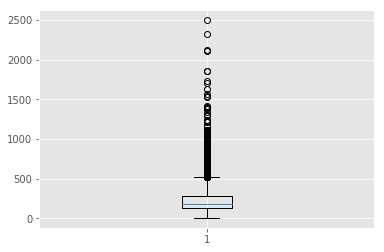

In [34]:
# Summarize review length
print("Review length: ")
result = [len(x) for x in X]
print("Mean %.2f words (%f)" % (np.mean(result), np.std(result)))
# plot review length
pyplot.boxplot(result)
pyplot.show()

Looking a box and whisker plot for the review lengths in words, we can probably see an exponential distribution that we can probably cover the mass of the distribution with a clipped length of 400 to 500 words.

# Set parameters

In [35]:
# set parameters:
#max_features = 5000
maxlen = 400
batch_size = 128
embedding_dims = 32
filters = 250
kernel_size = 3
hidden_dims = 250
epochs = 1

### Pad the Dataset
After we have loaded the dataset, we need to pad it so that all examples are the same size for submission to the network. We can do that by using a function in Keras.
Here we will bound reviews at maxlen words, truncating longer reviews and zero-padding shorter reviews.

Note that padding will not be needed if you are using sparse representatsions such as from a tfidf vectoriser. 


In [36]:
#Find the max example size and ensure that all other examples are padded to this size
print('Pad sequences (samples x time)')
x_train = sequence.pad_sequences(x_train, maxlen=maxlen)
x_test = sequence.pad_sequences(x_test, maxlen=maxlen)

#Print the data's shape (i.e. the size of each dimension) to check this is done correctly.
print('x_train shape:', x_train.shape)
print('x_test shape:', x_test.shape)
print('After padding the example looks:')
print(x_train[0])

num_classes = len(np.unique(y))
# convert class labels to binary class one-hot-encoded vectors
y_train_ohe = keras.utils.to_categorical(y_train, num_classes)
y_test_ohe = keras.utils.to_categorical(y_test, num_classes)

Pad sequences (samples x time)
x_train shape: (25000, 400)
x_test shape: (25000, 400)
After padding the example looks:
[  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   1  14  22  16  43 530 973   2   2  65 458   2  66   2   4 173
  36 256   5  25 100  43 838 112  50 670   2   9  35 480 284   5 150   4
 172 

# Exercise
Try to recreate the textual content after the padding has been added. You can use the word_to_id method as we did before.

### Creating the CNN Architecture
Now lets create a CNN object to store some aspects of our model. We need to identify several things at this stage:

(1) The parameters of our model (i.e. the hyperparameters of the CNN)

(2) The architecture of our model (i.e. the layers of the CNN)

Firstly lets define the architecture of the model by creating the layers. 

In [37]:
def create_model(max_features = 5000, embedding_dims = 50,  maxlen = 400, filters = 250, kernel_size = 3, hidden_dims = 250):
    #Firstly, instantiate a sequential model
    model = Sequential()

    #We can now add layers to this model.
    #Layers are added in the order of Input -> Output (meaning that they are sequential hence the name).
    #Start off with an efficient embedding layer which maps vocab indices into embedding_dims dimensions
    model.add(Embedding(max_features, embedding_dims, input_length=maxlen))
    
    #Now lets add a Dropout layer to avoid over fitting
    model.add(Dropout(0.2))

    #Add a Convolution1D, which will learn filters
    model.add(Conv1D(filters, kernel_size, padding='valid', activation='relu', strides=1))
    
    #The use max pooling:
    model.add(GlobalMaxPooling1D())

    #Add a hidden layer:
    model.add(Dense(hidden_dims))
    #With dropout
    model.add(Dropout(0.2))
    #And a ReLU activation
    model.add(Activation('relu'))

    #Project onto a single unit output layer
    model.add(Dense(num_classes)) # this will be two for the pos, neg class set
    #And squash it with a sigmoid, so that we can predit positive or negative
    #model.add(Activation('sigmoid'))
    model.add(Activation('softmax'))
    return model

## Create the Model

In [38]:
#Firstly, lets create our model by calling the function we just made
cnn = create_model()
cnn.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 400, 50)           250000    
_________________________________________________________________
dropout_3 (Dropout)          (None, 400, 50)           0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 398, 250)          37750     
_________________________________________________________________
global_max_pooling1d_2 (Glob (None, 250)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 250)               62750     
_________________________________________________________________
dropout_4 (Dropout)          (None, 250)               0         
_________________________________________________________________
activation_3 (Activation)    (None, 250)               0         
__________

### Setting the Hyperparameters
Now that we have a function to create our model, we can apply the training hyperparameters to it.

In [51]:
#Now lets state the hyperparameters as variables
batch_size = 128
epochs = 1
metrics = 'accuracy'

#Loss dictates what function we should use to determine the error
loss = 'binary_crossentropy'

#The optimizer is the function which controls how that error is applied to the network
optimizer = 'adam'

In [52]:
epochs=10 # takes a long time!! try 1 epoch first

#Now we can compile and train our model
#When compiling, note that accuracy is a list - this is because you can state more than one metric
cnn.compile(loss = loss,  optimizer = optimizer, metrics = ['accuracy'])

#The 'fit' function will train on your data, and evaluate the accuracy of its performance on the test set at each epoch
#First call the function and specify training data
history = cnn.fit(x_train, y_train_ohe, 
        #The identify the batch size
        batch_size = batch_size, 
        #Specify your epochs
        epochs = epochs, 
        #And identify your test data (remember to put brackets around both x_test and y_test)
        validation_data = (x_test, y_test_ohe))




Train on 25000 samples, validate on 25000 samples
Epoch 1/10
25000/25000 [==============================] - 392s 16ms/step - loss: 0.3135 - acc: 0.8680 - val_loss: 0.2963 - val_acc: 0.8735
Epoch 2/10
25000/25000 [==============================] - 386s 15ms/step - loss: 0.2683 - acc: 0.8893 - val_loss: 0.3088 - val_acc: 0.8682
Epoch 3/10
25000/25000 [==============================] - 394s 16ms/step - loss: 0.2362 - acc: 0.9059 - val_loss: 0.2811 - val_acc: 0.8811
Epoch 4/10
25000/25000 [==============================] - 396s 16ms/step - loss: 0.2120 - acc: 0.9149 - val_loss: 0.2826 - val_acc: 0.8831
Epoch 5/10
25000/25000 [==============================] - 391s 16ms/step - loss: 0.1837 - acc: 0.9288 - val_loss: 0.3055 - val_acc: 0.8799
Epoch 6/10
25000/25000 [==============================] - 389s 16ms/step - loss: 0.1602 - acc: 0.9374 - val_loss: 0.3159 - val_acc: 0.8780
Epoch 7/10
25000/25000 [==============================] - 389s 16ms/step - loss: 0.1367 - acc: 0.9488 - val_loss: 0.

# Evaluate on test set

In [53]:
loss, accuracy = cnn.evaluate(x_train, y_train_ohe, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = cnn.evaluate(x_test, y_test_ohe, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))

#score = cnn.evaluate(x_test, y_test_ohe, verbose=0)
#print('Test accuracy: ', score[1])


Training Accuracy: 0.9906
Testing Accuracy:  0.8762


Lets create helper function to visualize the loss and accuracy for the training and testing data based on the History callback. This callback, which is automatically applied to each Keras model, records the loss and additional metrics that can be added in the .fit() method. In this case, we are only interested in the accuracy. This helper function employs the matplotlib plotting library:

In [54]:
import matplotlib.pyplot as plt
plt.style.use('ggplot')

def plot_history(history):
    acc = history.history['acc']
    val_acc = history.history['val_acc']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, 'b', label='Training acc')
    plt.plot(x, val_acc, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

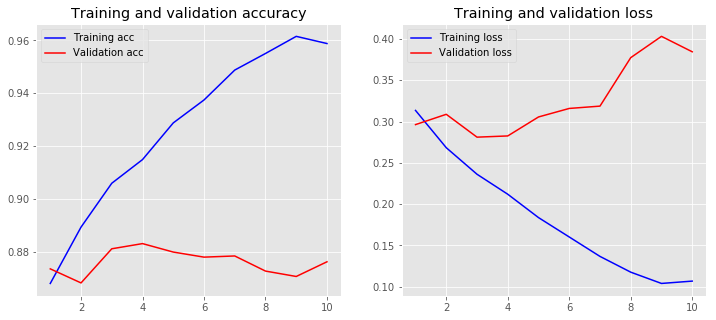

In [55]:
plot_history(history)

The above demonstrates clearly that there is over fitting since training accuracy is significantly better than test / validation.
The sweet spot is around 1 or 2 epochs.

# Exercise
- Compare the above CNN with  basic ANN i.e. no convolutional and padding layers
- With the CNN there is a lot of opportunity for further optimization, such as the use of deeper and/or larger convolutional layers. These will all take longer on the machine. One interesting idea is to set the max pooling layer to use an input length of 500. This would compress each feature map to a single 32 length vector and may boost performance.


# Preparing text from CSV files for CNN input

Often we may want to read our data from a CSV and if it is text content them we want to santise that text for instance using regular expressions or stemming etc (as we did last week). 
Once that is done we need to convert it into a index vector that can be input in to the CNN. 

For this we make use of the keras tokeniser  and texts_to_sequence encoder. 
from keras.preprocessing.text import Tokenizer

We look at how to do this next. 

In [101]:
import os
#from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer, TfidfVectorizer
#from sklearn.feature_extraction.text import TfidfTransformer

import nltk


In [102]:
#import regular expressions to clean up the text
import re
def preprocessor(text):
    text = re.sub('<[^>]*>', '', text) # remove all html markup
    emoticons = re.findall('(?::|;|=)(?:-)?(?:\)|\(|D|P)', text) # findall the emoticons
    
    # remove the non-word chars '[\W]+'
    # append the emoticons to end 
    #convert all to lowercase
    # remove nose char for consistency
    text = (re.sub('[\W]+', ' ', text.lower()) +
            ' '.join(emoticons).replace('-', '')) 
    return text

In [110]:
from nltk.stem.porter import PorterStemmer
df = pd.read_csv('movie_data_cat.csv', encoding='utf-8')

class_mapping = {label:idx for idx,label in enumerate(np.unique(df['sentiment']))}

#use the mapping dictionary to transform the class labels into integers

df['sentiment'] = df['sentiment'].map(class_mapping)


df['review'] = df['review'].apply(preprocessor)

#make a train test split
X_text_train = df.loc[:2500, 'review'].values
Y_train = df.loc[:2500, 'sentiment'].values
X_text_test = df.loc[2500:5000, 'review'].values
Y_test = df.loc[2500:5000, 'sentiment'].values

# convert class labels to binary class one-hot-encoded vectors
Y_train_ohe = keras.utils.to_categorical(Y_train, num_classes)
Y_test_ohe = keras.utils.to_categorical(Y_test, num_classes)

In [104]:
print(X_text_train[0])

in 1974 the teenager martha moxley maggie grace moves to the high class area of belle haven greenwich connecticut on the mischief night eve of halloween she was murdered in the backyard of her house and her murder remained unsolved twenty two years later the writer mark fuhrman christopher meloni who is a former la detective that has fallen in disgrace for perjury in o j simpson trial and moved to idaho decides to investigate the case with his partner stephen weeks andrew mitchell with the purpose of writing a book the locals squirm and do not welcome them but with the support of the retired detective steve carroll robert forster that was in charge of the investigation in the 70 s they discover the criminal and a net of power and money to cover the murder murder in greenwich is a good tv movie with the true story of a murder of a fifteen years old girl that was committed by a wealthy teenager whose mother was a kennedy the powerful and rich family used their influence to cover the murd

### How do we convert the text to a format suited to keras CNN input?

In [132]:
from keras.preprocessing.text import Tokenizer
# create the tokenizer
tokeniser = Tokenizer(num_words=5000)

# fit the tokenizer on the documents
tokeniser.fit_on_texts(X_text_train)

# summarize what was learned
#print(tokeniser.word_counts)
#print(tokeniser.word_index)
#print(tokeniser.word_docs)
print('Num of training documnets', tokeniser.document_count)


# integer encode documents
X_encoded_train = tokeniser.texts_to_sequences(X_text_train) 
#X_encoded_train2 = tokeniser.sequences_to_matrix(X_encoded_train, mode='tfidf').tolist() # can try for tfidf representation
train_vocab_size = len(tokeniser.word_index) + 1 # Adding 1 because of reserved 0 index

X_encoded_test = tokeniser.texts_to_sequences(X_text_test) 
test_vocab_size = len(tokeniser.word_index) + 1 # Adding 1 because of reserved 0 index

print ('train vocabulary size:', train_vocab_size)
print ('test vocabulary size:', test_vocab_size)


Num of training documnets 2501
train vocabulary size: 28784
test vocabulary size: 28784
[8, 1, 2221, 2296, 4002, 1229, 1347, 5, 1, 294, 821, 1371, 4, 4663, 799, 21, 1, 303, 4664, 4, 1889, 53, 13, 1836, 8, 1, 4, 40, 342, 3, 40, 477, 4665, 1720, 106, 152, 290, 1, 513, 653, 1249, 34, 6, 2, 1031, 1605, 1348, 11, 46, 2574, 8, 15, 8, 654, 1450, 2485, 3, 1250, 5, 1251, 5, 4003, 1, 393, 16, 24, 1721, 2088, 2486, 4666, 2575, 16, 1, 1606, 4, 437, 2, 295, 1, 3, 78, 23, 2089, 93, 18, 16, 1, 1284, 4, 1, 1348, 958, 514, 11, 13, 8, 2576, 4, 1, 2390, 8, 1, 1451, 12, 32, 1837, 1, 1517, 3, 2, 4, 633, 3, 292, 5, 934, 1, 477, 477, 8, 6, 2, 47, 214, 17, 16, 1, 254, 62, 4, 2, 477, 4, 2, 2805, 152, 164, 240, 11, 13, 1838, 33, 2, 4311, 2221, 669, 395, 13, 2, 2222, 1, 969, 3, 1059, 215, 323, 61, 2297, 5, 934, 1, 477, 15, 52, 74, 1720, 152, 192, 2, 1348, 3, 8, 13, 520, 5, 90, 1, 4312, 604, 13, 1838, 1, 1126, 263, 1, 2390, 4, 653, 3, 1, 218, 511, 4, 2296, 8, 18, 39, 6, 2, 697, 4, 1, 1722, 8, 1, 56, 2032, 6, 1349

In [119]:
#Find the max example size and ensure that all other examples are padded to this size
# NOTE: padding is not needed when using tfidf sparce representations
print('Pad sequences (samples x time)')
X_train = sequence.pad_sequences(X_encoded_train, maxlen=maxlen)
X_test = sequence.pad_sequences(X_encoded_test, maxlen=maxlen)

#Print the data's shape (i.e. the size of each dimension) to check this is done correctly.
print('x_train shape:', X_train.shape)
print('x_test shape:', X_test.shape)
print('After padding the example looks:')
print(X_train[0])

Pad sequences (samples x time)
x_train shape: (2501, 400)
x_test shape: (2501, 400)
After padding the example looks:
[   0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0 

# Exercise
Now that the input is in the same format as we had when we loaded it directly from Keras; we can now use this as input into a CNN. 
This means that you can now compare the models from last week on text classification with the CNN model using similar text pre-processing steps. 

In [120]:
cnn.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 400, 50)           250000    
_________________________________________________________________
dropout_3 (Dropout)          (None, 400, 50)           0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 398, 250)          37750     
_________________________________________________________________
global_max_pooling1d_2 (Glob (None, 250)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 250)               62750     
_________________________________________________________________
dropout_4 (Dropout)          (None, 250)               0         
_________________________________________________________________
activation_3 (Activation)    (None, 250)               0         
__________

In [121]:
history = cnn.fit(X_train, Y_train_ohe, 
        #The identify the batch size
        batch_size = batch_size, 
        #Specify your epochs
        epochs = 1, 
        #And identify your test data (remember to put brackets around both x_test and y_test)
        validation_data = (X_test, Y_test_ohe))


Train on 2501 samples, validate on 2501 samples
Epoch 1/1
2501/2501 [==============================] - 26s 10ms/step - loss: 0.5016 - acc: 0.8069 - val_loss: 0.5919 - val_acc: 0.6877
